In [2]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats

import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations
import os
import requests
import ROOT
import root_numpy as rtnp
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.15/01


In [3]:
dataSelection = 'LAB'
runI = [2154]
start_image_to_read = 0
max_image_to_read = 0
for nRi in range(0,len(runI)):
#############  mean and sigma file generator ############################
    try:
        print ('Download and open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
        tmp_file = cy.swift_download_file(cy.swift_root_file(dataSelection, runI[nRi]))
        print ('Open file: '+tmp_file)
        f  = ROOT.TFile.Open(tmp_file);
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        pic, wfm = cy.root_TH2_name(f)
        max_image = len(pic)
        max_wfm = len(wfm)
        print ("# of Images (TH2) Files: %d " % (max_image))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        nImag=max_image
    
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
    if max_image_to_read != 0:
        nImag = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (start_image_to_read, nImag))
    
    m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
    s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

    n0 = 0
    for iTr in range(start_image_to_read, nImag):

        if iTr % 50 == 0:
            print (iTr, ' >> Close and re-Open: ', tmp_file)
            f.Close()
            f  = ROOT.TFile.Open(tmp_file);

        image = rtnp.hist2array(f.Get(pic[iTr])).T
        m_image += image
        s_image += image**2 
        if n0 > 0:  # print progress and debung info for poit 200, 200...
            print ("Image[200,200]: %d => %.2f %.2f %.2f " % (iTr,
                                             image[200,200],
                                             np.sqrt((s_image[200,200] - 
                                                     m_image[200,200]**2 
                                                      / (n0+1)) / n0),
                                             m_image[200,200]/(n0+1),
                                             ))
        n0 += 1
    m_image = m_image/n0
    s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))
    
###### print Info and Save OutPut ######################################
    
    print ("sigma %f" % (s_image[200,200]))
    fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
    cy.write_image_h5(fileoutm, m_image)
    fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
    cy.write_image_h5(fileouts, s_image)
    print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))
    if not cy.rm_file(tmp_file):
        print (">> File "+tmp_file+" removed")

Download and open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02154.root


  1.1%   4145152 / 393793870

  2.8%  10829824 / 393793870

  5.7%  22462464 / 393793870

  8.4%  33161216 / 393793870

 11.8%  46473216 / 393793870

 15.4%  60497920 / 393793870

 18.4%  72499200 / 393793870

 22.0%  86630400 / 393793870

 25.7% 101089280 / 393793870

 29.3% 115286016 / 393793870

 33.0% 129843200 / 393793870

 36.6% 144064512 / 393793870

 39.6% 155959296 / 393793870

 42.2% 166223872 / 393793870

 44.8% 176603136 / 393793870

 47.3% 186449920 / 393793870

 49.8% 196206592 / 393793870

 52.2% 205520896 / 393793870

 54.8% 215810048 / 393793870

 57.5% 226287616 / 393793870

 60.1% 236494848 / 393793870

 62.3% 245374976 / 393793870

 64.7% 254967808 / 393793870

 67.2% 264699904 / 393793870

 70.1% 276193280 / 393793870

 72.4% 284934144 / 393793870

 74.6% 293683200 / 393793870

 77.0% 303210496 / 393793870

 80.1% 315301888 / 393793870

 82.9% 326279168 / 393793870

 85.9% 338321408 / 393793870

 89.0% 350461952 / 393793870

 91.9% 361840640 / 393793870

 94.9% 373710848 / 393793870

 97.9% 385589248 / 393793870

100.0% 393797632 / 393793870


Open file: ./tmp.28549.root
Find Keys: 210
# of Images (TH2) Files: 105 
# of Waveform (TH2) Files: 105 
0  >> Close and re-Open:  ./tmp.28549.root
Image[200,200]: 1 => 101.00 14.14 111.00 
Image[200,200]: 2 => 119.00 11.02 113.67 
Image[200,200]: 3 => 98.00 11.93 109.75 
Image[200,200]: 4 => 97.00 11.80 107.20 
Image[200,200]: 5 => 98.00 11.20 105.67 
Image[200,200]: 6 => 100.00 10.45 104.86 
Image[200,200]: 7 => 97.00 10.06 103.88 
Image[200,200]: 8 => 98.00 9.61 103.22 
Image[200,200]: 9 => 98.00 9.21 102.70 
Image[200,200]: 10 => 98.00 8.86 102.27 
Image[200,200]: 11 => 102.00 8.44 102.25 
Image[200,200]: 12 => 96.00 8.27 101.77 
Image[200,200]: 13 => 100.00 7.96 101.64 
Image[200,200]: 14 => 98.00 7.73 101.40 
Image[200,200]: 15 => 96.00 7.58 101.06 
Image[200,200]: 16 => 94.00 7.54 100.65 
Image[200,200]: 17 => 106.00 7.42 100.94 
Image[200,200]: 18 => 97.00 7.27 100.74 
Image[200,200]: 19 => 98.00 7.10 100.60 
Image[200,200]: 20 => 98.00 6.95 100.48 
Image[200,200]: 21 => 97.00 

In [4]:
if not cy.rm_file(tmp_file):
        print (">> File "+tmp_file+" removed")

/bin/rm: cannot remove ‘./tmp.28549.root’: No such file or directory


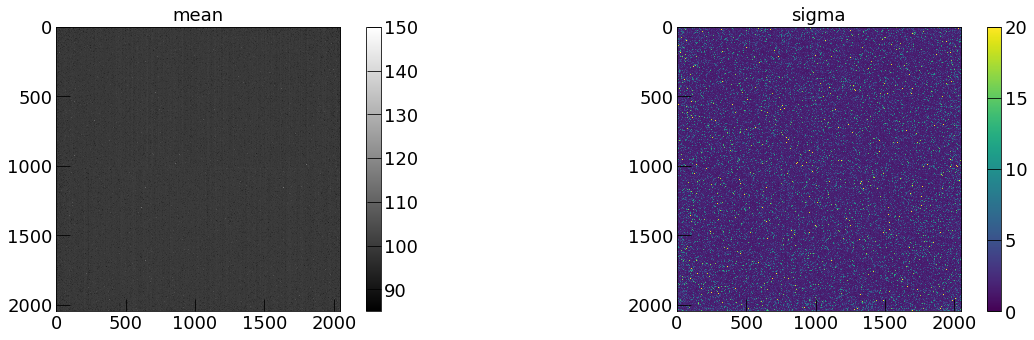

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


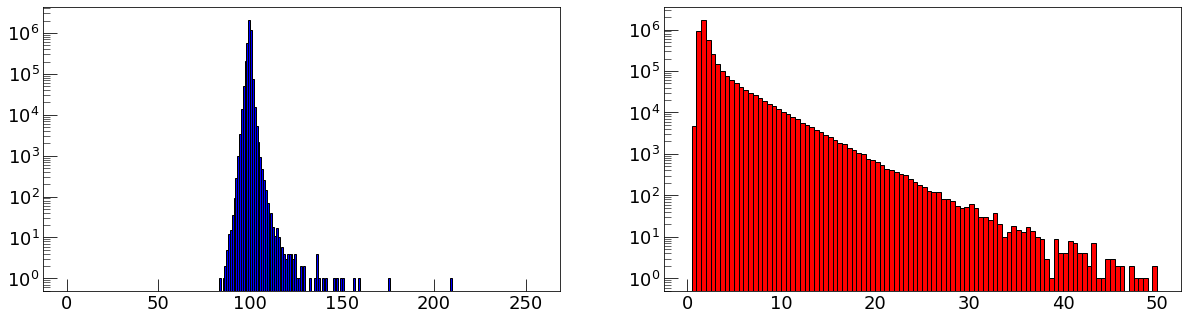

In [5]:
cy.set_atlas_style('long')
run = 1748# 2340
try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    imagem = cy.read_image_h5(fileoutm)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    images = cy.read_image_h5(fileouts)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)


fig, ax = plt.subplots(1,2)
im = ax[0].imshow(imagem, cmap="gray", vmin=85,vmax=150)
fig.colorbar(im, ax=ax[0])
ax[0].set_title("mean")
ax[1].set_title("sigma")
im = ax[1].imshow(images, vmin=0,vmax=20)
fig.colorbar(im, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1,2)
ax[0].hist(imagem.ravel(), bins=256, range=(0.0, 256.0), fc='b', ec='k')
ax[1].hist(images.ravel(), bins=100, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")

plt.show()